In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [78]:
df=pd.read_csv("datasets/diabetes.csv")

In [79]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [80]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

array([[<AxesSubplot: title={'center': 'Pregnancies'}>,
        <AxesSubplot: title={'center': 'Glucose'}>,
        <AxesSubplot: title={'center': 'BloodPressure'}>],
       [<AxesSubplot: title={'center': 'SkinThickness'}>,
        <AxesSubplot: title={'center': 'Insulin'}>,
        <AxesSubplot: title={'center': 'BMI'}>],
       [<AxesSubplot: title={'center': 'DiabetesPedigreeFunction'}>,
        <AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Outcome'}>]], dtype=object)

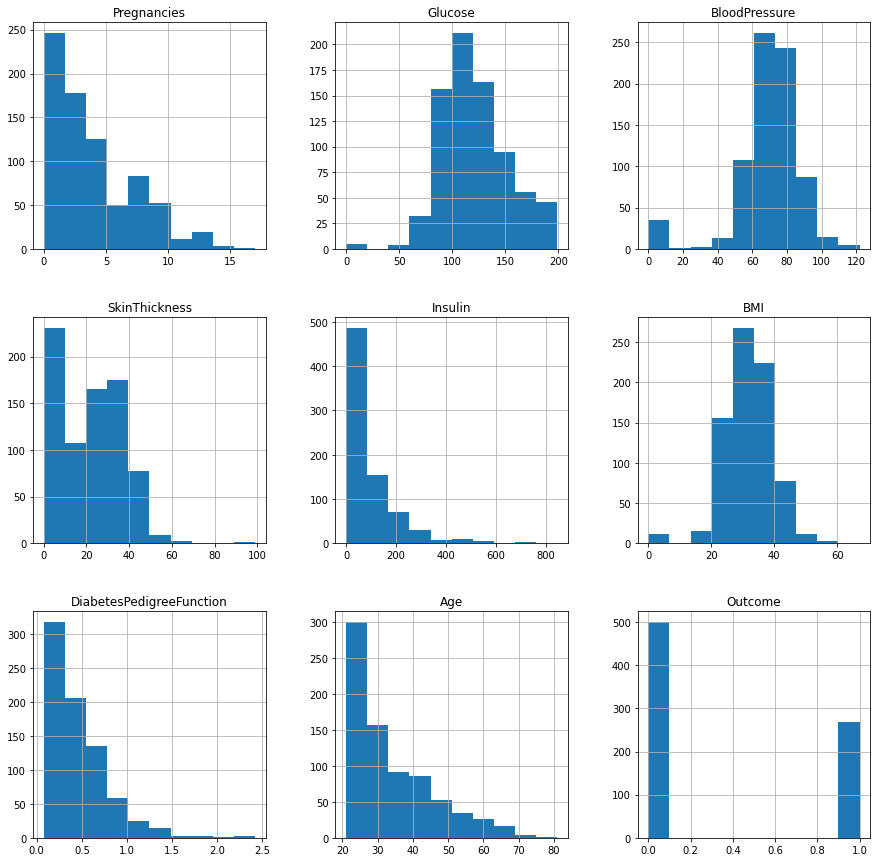

In [81]:
df.hist(figsize=(15,15))

<AxesSubplot: >

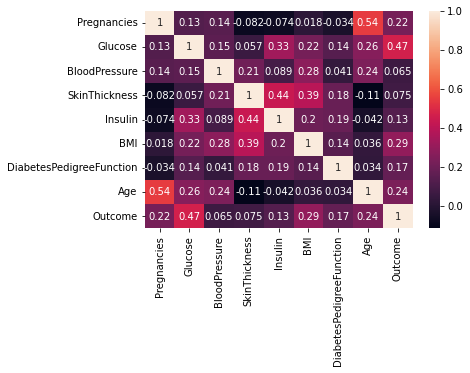

In [82]:
#correlation Matrix
coR=df.corr()
sns.heatmap(coR,annot=True)

In [83]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Data preprocessing

In [84]:
 #these feature cannot be 0
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)


In [85]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [86]:
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [87]:
def targetMedian(var):   
    res = df[df[var].notnull()]
    res = res[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    #print(res.head())
    return res



In [88]:

cols = df.columns
cols = cols.drop("Outcome")
for i in cols:
    targetMedian(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = targetMedian(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = targetMedian(i)[i][1]

In [89]:
# outlier detection 

In [90]:
#IQR
def IQR_range(dataframe, variable):  
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit


#has a outlier or not
def hasOutliers(dataframe, variable):
    lowLimit, upLimit = IQR_range(dataframe, variable)
    if dataframe[(dataframe[variable] < lowLimit) | (dataframe[variable] > upLimit)].any(axis=None):
        print(variable, "yes")
    else: 
        print(variable, "no")
        
#replacing outlier with lower and upper limit     
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        lowLimit, upLimit = IQR_range(dataframe, variable)
        dataframe.loc[(dataframe[variable] < lowLimit), variable] = lowLimit
        dataframe.loc[(dataframe[variable] > upLimit), variable] = upLimit

In [91]:
for col in df.columns: 
    hasOutliers(df,col)

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [92]:
replace_with_thresholds(df, df.columns)

In [93]:
for col in df.columns:
    hasOutliers(df, col)


Pregnancies no
Glucose no
BloodPressure no
SkinThickness no
Insulin no
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [94]:
#Feature Engineering
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df["NewBMI"] = NewBMI

df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [95]:
df.loc[(df.Outcome == 1) & (df.Insulin <= 100) , "Insulin"] = 70
df.loc[(df.Outcome == 0) & (df.Insulin >= 200 ) , "Insulin"] = 200
df.loc[(df.Outcome == 0) & (df.Glucose >= 175 ) , "Glucose"] = 175
df.loc[(df.Outcome == 1) & (df.Glucose <= 80 ) , "Glucose"] = 80
df.loc[(df.Outcome == 0) & (df.Pregnancies >= 13 ) , "Pregnancies"] = 13
df.loc[(df.Outcome == 0) & (df.DiabetesPedigreeFunction >= 1.3 ) , "DiabetesPedigreeFunction"] = 1.3
df.loc[(df.Outcome == 0) & (df.BMI >= 50 ) , "BMI"] = 50
df["NEW_g_p"] = (df.Glucose * df.Pregnancies) 
df["NEW_i_g"] = (df.Glucose * df.Insulin)

In [96]:
df['New_Glucose'] = pd.cut(x=df['Glucose'], bins=[0,74,99,139,200],labels = ["Low","Normal","Overweight","High"])

In [97]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [98]:
df = df.assign(NewInsulinScore=df.apply(set_insulin, axis=1))

In [99]:
df.shape

(768, 14)

In [100]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NEW_g_p,NEW_i_g,New_Glucose,NewInsulinScore
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1.0,Obesity 1,888.0,25086.0,High,Abnormal
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0.0,Overweight,85.0,8712.5,Normal,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1.0,Normal,1464.0,31018.5,High,Abnormal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0,Overweight,89.0,8366.0,Normal,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1.0,Obesity 3,0.0,23016.0,Overweight,Abnormal
5,5.0,116.0,74.0,27.0,102.5,25.6,0.201,30.0,0.0,Overweight,580.0,11890.0,Overweight,Normal
6,3.0,80.0,50.0,32.0,70.0,31.0,0.248,26.0,1.0,Obesity 1,240.0,5600.0,Normal,Normal
7,10.0,115.0,70.0,27.0,102.5,35.3,0.134,29.0,0.0,Obesity 2,1150.0,11787.5,Overweight,Normal
8,2.0,197.0,70.0,42.5,270.0,30.5,0.158,53.0,1.0,Obesity 1,394.0,53190.0,High,Abnormal
9,8.0,125.0,96.0,32.0,169.5,34.3,0.232,54.0,1.0,Obesity 1,1000.0,21187.5,Overweight,Abnormal


In [101]:
# one- hot encoding
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

In [102]:
categorical_columns = [col for col in df.columns
                           if len(df[col].unique()) <= 10
                      and col != "Outcome"]

In [103]:
df[categorical_columns].head()

,NewBMI,New_Glucose,NewInsulinScore
0,Obesity 1,High,Abnormal
1,Overweight,Normal,Normal
2,Normal,High,Abnormal
3,Overweight,Normal,Normal
4,Obesity 3,Overweight,Abnormal


In [104]:
df, new_cols_ohe = one_hot_encoder(df,categorical_columns)
new_cols_ohe

['NewBMI_Obesity 1',
 'NewBMI_Obesity 2',
 'NewBMI_Obesity 3',
 'NewBMI_Overweight',
 'NewBMI_Underweight',
 'New_Glucose_Normal',
 'New_Glucose_Overweight',
 'New_Glucose_High',
 'NewInsulinScore_Normal']

In [105]:
y = df["Outcome"]
X=df.drop(["Outcome"],axis=1)
# X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
#                      'NewInsulinScore_Normal','New_Glucose_Normal', 'New_Glucose_Overweight', 'New_Glucose_High'], axis = 1)
# cols = X.columns
# index = X.index

In [106]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_g_p,NEW_i_g,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,New_Glucose_Normal,New_Glucose_Overweight,New_Glucose_High,NewInsulinScore_Normal
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,888.0,25086.0,1,0,0,0,0,0,0,1,0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,85.0,8712.5,0,0,0,1,0,1,0,0,1
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1464.0,31018.5,0,0,0,0,0,0,0,1,0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,89.0,8366.0,0,0,0,1,0,1,0,0,1
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,0.0,23016.0,0,0,1,0,0,0,1,0,0


In [107]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=0.2)

In [108]:
# #feature scaling
# scaler = StandardScaler()
# train_X = scaler.fit_transform(X)
# #test_X = scaler.transform(x)

In [109]:
# X.head()

In [110]:
xgb = GradientBoostingClassifier(learning_rate= 0.1,max_depth= 5,min_samples_split= 0.1,n_estimators= 100,subsample= 1.0).fit(x_train,y_train)

In [111]:
cross_val_score(xgb, x_test, y_test, cv = 10).mean()

0.8695833333333333

In [112]:
pickle.dump(xgb, open('Diabetes.pkl', 'wb'))

<IPython.core.display.Javascript object>